In [1]:
# Aca resolvemos una ODE con condición inicial
# Problema 6 del articulo
# Artificial Neural Networks for Solving Ordinary and Partial Differential Equations

importamos los paquetes necesarios para el entrenamiento

In [2]:

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

Se resuelve la ecuación diferencial 

\begin{align}
\nabla^2 \psi(x,y) = e^{-\frac{ax + y}{5}}\left\{ \left[ -\frac{4}{5}a^3x - \frac{2}{5} + 2a^2 \right]\cos(a^2x^2 + y) + \left[ \frac{1}{25} - 1 - 4a^4x^2 + \frac{a^2}{25}  \right]\sin(a^2x^2 + y) \right\}
\end{align}

definición de la arquitectura de la red neuronal

In [3]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers):
        super(Model, self).__init__()
        self.layers = nn.ModuleList([
            nn.Linear(input_size, hidden_size),
            nn.Sigmoid()
        ])
        for _ in range(num_hidden_layers):
            self.layers.extend([
                nn.Linear(hidden_size, hidden_size),
                nn.Sigmoid()
            ])
        self.layers.append(nn.Linear(hidden_size, output_size))

    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)
        return out

input_size = 2
hidden_size = 124
output_size = 1
num_hidden_layers = 20

N = Model(input_size, hidden_size, output_size, num_hidden_layers)

### Red de prueba

In [4]:
a = 3
Psi_exact = lambda x, y: torch.exp(-(a*x +y)/5)*torch.sin(a**2*x**2 + y)
f0 = lambda y: Psi_exact(torch.tensor(0),y)
f1 = lambda y: Psi_exact(torch.tensor(1.0),y)
g0 = lambda x: Psi_exact(x,torch.tensor(0))
g1 = lambda x: Psi_exact(x,torch.tensor(1.0))

A = lambda x, y: ((1 - x)*f0(y) + x*f1(y) 
                      + (1 - y)*(g0(x) - ((1 - x)*g0(0) + x*g0(torch.tensor(1.0)))) 
                      + y*(g1(x) - ((1 - x)*g1(0) + x*g1(torch.tensor(1.0)))))

Psi_estimate = lambda x, y: A(x, y) + x*(1 - x)*y*(1 - y)*N(torch.stack((x, y), dim=1))

In [5]:
# ahora definimos la función f(.)
f = lambda x, y: torch.exp(-(a*x + y)/5)*((-4/5*a**3*x - 2/5 + 2*a**2)*torch.cos(a**2*x**2 + y) + (1/25 - 1 - 4*a**4*x**2 + (a**2)/25)*torch.sin(a**2*x**2 + y))

In [6]:
def loss(x, y):
    x.requires_grad = True
    y.requires_grad = True
    outputs = Psi_estimate(x, y)
    Psi_estimate_x = torch.autograd.grad(outputs,x, grad_outputs=torch.ones_like(outputs),create_graph=True)[0] # esta es la derivada de Psi con respecto a x, i.e., dPsi/dx
    dPsi_estimate_x = torch.autograd.grad(Psi_estimate_x,x, grad_outputs=torch.ones_like(Psi_estimate_x),create_graph=True)[0] # esta es la derivada de dPsi/dx con respecto a x, i.e., d^2Psi/dx^2
    Psi_estimate_y = torch.autograd.grad(outputs,y, grad_outputs=torch.ones_like(outputs),create_graph=True)[0] # esta es la derivada de Psi con respecto a y, i.e., dPsi/dy
    dPsi_estimate_y = torch.autograd.grad(Psi_estimate_y,y, grad_outputs=torch.ones_like(Psi_estimate_y),create_graph=True)[0] # esta es la derivada de dPsi/dy con respecto a y, i.e., d^2Psi/dy^2
    return torch.mean((dPsi_estimate_x + dPsi_estimate_y - f(x, y))**2)


In [7]:
optimizer = torch.optim.LBFGS(N.parameters())

In [8]:
x = torch.linspace(0, 1, 10)
y = torch.linspace(0, 1, 10)
 

In [9]:
def closure():
    optimizer.zero_grad()
    loss_value = loss(x, y)
    loss_value.backward()
    return loss_value

for i in range(100):
    optimizer.step(closure)

### Comparación de resultados

c:\Users\Donovan\anaconda3\envs\pytorch\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


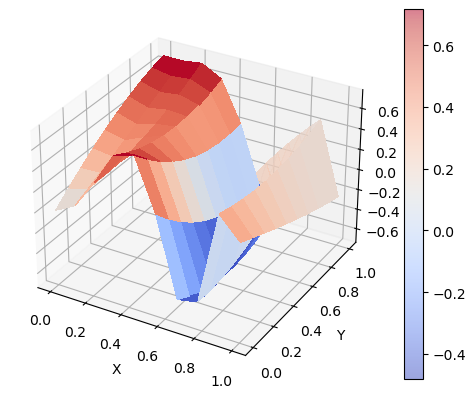

In [10]:
from ipywidgets import interact
xx = np.linspace(0, 1, 10)
yy = np.linspace(0, 1, 10)

XX, YY = np.meshgrid(xx, yy)
yt = np.exp(-(a*XX + YY)/5)*np.sin(a**2*XX**2 + YY)

xx_torch = torch.linspace(0, 1, 10)
yy_torch = torch.linspace(0, 1, 10)

XX_torch, YY_torch = torch.meshgrid(xx_torch, yy_torch)

psi_estimates = np.zeros((len(xx), len(yy)))

# iterar a través de la malla y evaluar el modelo en cada punto
for i in range(len(xx)):
    for j in range(len(yy)):
        xx1 = xx_torch[i].reshape(1)
        yy1 = yy_torch[j].reshape(1)
        psi_estimates[i,j] = Psi_estimate(xx1, yy1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(XX_torch, YY_torch, psi_estimates, cmap='coolwarm', linewidth=0, antialiased=False)
surf = ax.plot_surface(XX, YY, yt, cmap='coolwarm', linewidth=0, antialiased=False, alpha=0.5)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
fig.colorbar(surf)


### Gráfica interactiva

In [11]:
def plot_graph(angle1, angle2):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(XX_torch, YY_torch, psi_estimates, cmap='coolwarm', linewidth=0, antialiased=False)
    surf = ax.plot_surface(XX, YY, yt, cmap='coolwarm', linewidth=0, antialiased=False, alpha=0.5)
    ax.view_init(angle1, angle2)  # cambiar el ángulo de vista
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    fig.colorbar(surf)
    plt.show()

interact(plot_graph, angle1=(0, 90, 30), angle2=(0, 360, 30))

interactive(children=(IntSlider(value=30, description='angle1', max=90, step=30), IntSlider(value=180, descrip…

<function __main__.plot_graph(angle1, angle2)>